<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Functions-and-Classes" data-toc-modified-id="Functions-and-Classes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions and Classes</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Loading-Images-and-Captions" data-toc-modified-id="Loading-Images-and-Captions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loading Images and Captions</a></span></li><li><span><a href="#Split:-Train-and-Test" data-toc-modified-id="Split:-Train-and-Test-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split: Train and Test</a></span></li></ul></div>

# Image Captioning - Advanced Statistics Topics

In this notebook, we train several models and save the results of its metrics.

## Import Libraries

In this section we import the requiere libraries and establish the connection with Google Drive.

In [1]:
# Se importan las librerias necesarias
import numpy as np
import pandas as  pd
import os
import gzip
import timeit
import json
import collections
import random
import time
from PIL import Image
from tqdm import tqdm
# from google.colab import drive # Necesario para GoogleColab

# Tensorflow 2.x
import tensorflow as tf # Not required for this notebook 
print('TENSORFLOW VERSION: {}'.format(tf.__version__))

TENSORFLOW VERSION: 2.4.1


In [2]:
# Se fija el directorio referencia con el se conecta colab a drive # Necesario para GoogleColab
# drive.mount('/content/drive')

In [3]:
# Se guarda en una variable el directorio del curso

# Directorio de los datos
# data_folder = 'drive/MyDrive/Colab Notebooks/AST-ImageCaptioning/Data/'
data_folder = '../Data/'

## Functions and Classes

In [4]:
# Load an image and adjust it to InceptionV3 networks
def image_to_v3_format(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Data Preprocessing

In this section we process the images and its respective captions.

In [5]:
# Download caption annotation files
annotation_folder = data_folder + '/Captions/'
if not os.path.exists(os.path.abspath('.') + '/' + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                              cache_subdir=os.path.abspath('.') + '/' + data_folder,
                              origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                              extract=True)
    os.rename(data_folder + 'annotations/', annotation_folder)
    annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
    os.remove(annotation_zip)

252878848/252872794 [==============================] - 112s 0us/step


In [9]:
# Download image files
image_folder = data_folder + 'Images/'
if not os.path.exists(os.path.abspath('.') + '/' + image_folder):
    image_zip = tf.keras.utils.get_file('Train.zip',
                                      cache_subdir=os.path.abspath('.') + '/' + image_folder,
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
#     os.rename(image_folder + 'train2014/', image_folder + 'Train/') # Better to change the name directly
    PATH = image_folder + 'Train/'
    os.remove(image_zip)
else:
    PATH = image_folder + 'Train/'

13510574080/13510573713 [==============================] - 1440s 0us/step


## Loading Images and Captions

In [10]:
# Process all the captions
with open(annotation_folder + 'captions_train2014.json', 'r') as f:
    captions = json.load(f)
    
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in captions['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [11]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths.copy()#[:6000]
print('THE NUMBER OF IMAGES IS {} AND THERE IS {} CAPTIONS'.format(len(train_image_paths), len(captions['annotations'])))

THE NUMBER OF IMAGES IS 82783 AND THERE IS 414113 CAPTIONS


In [12]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

Caption: <start> A baseball player running to catch a baseball during a game.  <end>


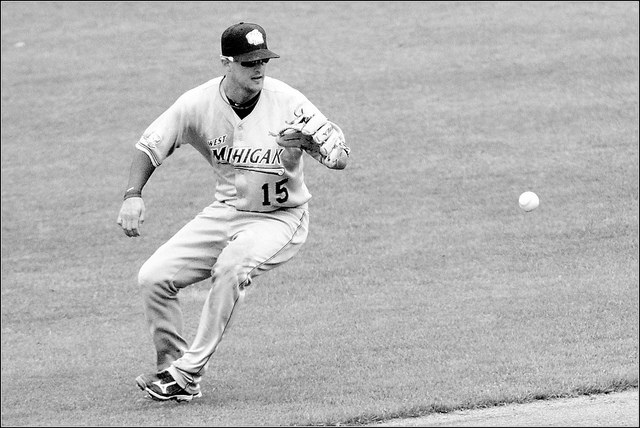

In [13]:
sample_image = 1608
print('Caption:', train_captions[sample_image])
Image.open(img_name_vector[sample_image])

In [14]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 9s 0us/step


In [17]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# It can be done for big batches because our vm has 128gb of ram
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(image_to_v3_format, num_parallel_calls=tf.data.AUTOTUNE).batch(2**6) 

In [22]:
if not os.path.exists(os.path.abspath('.') + '/' + image_folder + 'InceptionV3/'):
    os.makedirs(os.path.abspath('.') + '/' + image_folder + 'InceptionV3/')
    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
   



        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            path_of_feature = path_of_feature.split('/')[-1]
            np.save(image_folder + 'InceptionV3/' + path_of_feature, bf.numpy())
        del batch_features, bf, p, img, path

100%|██████████| 1294/1294 [1:40:32<00:00,  4.66s/it]


In [34]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split: Train and Test

In [40]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [43]:
print('NUMBER OF TRAIN IMAGES: {} AND NUMBER OF TRAIN CAPTIONS: {}'.format(len(img_name_train), len(cap_train)))
print('NUMBER OF TEST IMAGES: {} AND NUMBER OF TEST CAPTIONS: {}'.format(len(img_name_val), len(cap_val)))

NUMBER OF TRAIN IMAGES: 331291 AND NUMBER OF TRAIN CAPTIONS: 331291
NUMBER OF TEST IMAGES: 82822 AND NUMBER OF TEST CAPTIONS: 82822


In [44]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [154]:
# Load the numpy files
def map_func(img_name, cap):
    img_new_name = image_folder + 'InceptionV3/' + img_name.decode('utf-8').split('/')[-1]
    img_new_name = str.encode(img_new_name)
    img_tensor = np.load(img_new_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [155]:
img_name_train[1]

'../Data/Images/Train/COCO_train2014_000000138137.jpg'

In [156]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [157]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [158]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [159]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [160]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [161]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [162]:
checkpoint_path = "./Checkpoints/Train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [163]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [164]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [166]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8600
Epoch 1 Batch 100 Loss 1.0721
Epoch 1 Batch 200 Loss 0.8955
Epoch 1 Batch 300 Loss 0.8489


KeyboardInterrupt: 

# End